# Find the Measured Velocities


In [123]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [124]:
import os
import sys
from typing import Tuple
from datetime import datetime
from pathlib import Path


def recursive_root(path: str, find="sumo-uc-2023"):
    if os.path.split(path)[-1] == find:
        return Path(path)
    return recursive_root(os.path.split(path)[0], find=find)


ROOT = recursive_root(os.path.abspath("."))
sys.path.append(str(ROOT))


## Read the SUMO Configurations


In [125]:
from src.walk_configs import walk_configs


In [126]:
from constants import experiment_path, default_experiment_path

In [127]:
configs = list(walk_configs(experiment_path))
default_configs = list(walk_configs(default_experiment_path))


### Read the File


In [128]:
import pandas as pd


def get_fuel(config, **aditional_params) -> float:
    # pandas
    df = pd.read_csv(config.Blocks.FuelTotalConfig.output_path, header=None, names=["time", "fuel"])
    for param, value in aditional_params.items():
        df[param] = value
    return df


In [129]:
default_configs[0].Metadata.output == str(default_experiment_path )

True

In [130]:
fuel = [
    get_fuel(
        config,
        **{
            "carFollowModel": config.Blocks.CFTableConfig.additional_params.carFollowModel,
            "seed": config.Blocks.SeedConfig.seed,
        },
    )
    for config in configs
]
fuel_df = pd.concat(fuel)
SUMO_GASOLINE_GRAM_TO_JOULE: float = 43.4e-3

In [131]:
fuel = [
    get_fuel(
        config,
        **{
            "carFollowModel": config.Blocks.CFSimpleConfig.cf_params.carFollowModel,
            "seed": config.Blocks.SeedConfig.seed,
        },
    )
    for config in default_configs
]
fuel_df_defaults = pd.concat(fuel)

In [132]:
fuel_df_defaults['carFollowModel'] = fuel_df_defaults['carFollowModel'] + ' (default)'

In [133]:
fuel_df = pd.concat([fuel_df, fuel_df_defaults])

In [134]:
fuel_df["fuel"] = (fuel_df["fuel"] / SUMO_GASOLINE_GRAM_TO_JOULE) * 0.00133529


## Plot the Histograms


In [144]:
tmp_df = fuel_df.groupby(["carFollowModel", 'seed'])["fuel"].sum().reset_index().groupby("carFollowModel")["fuel"].agg(
    ("mean", lambda x: x.quantile(0.05), lambda x: x.quantile(0.95))
)
tmp_df.columns = ["mean", "lower", "upper"]

tmp_df = tmp_df.round(0).astype(int)

/var/folders/96/_9h8bqbx4gqcmb4td8q57q8w0000gn/T/ipykernel_41235/527055912.py:13: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_df = fuel_df.groupby(["carFollowModel", "seed"]).sum().reset_index()


Text(0, 0.5, 'Density')

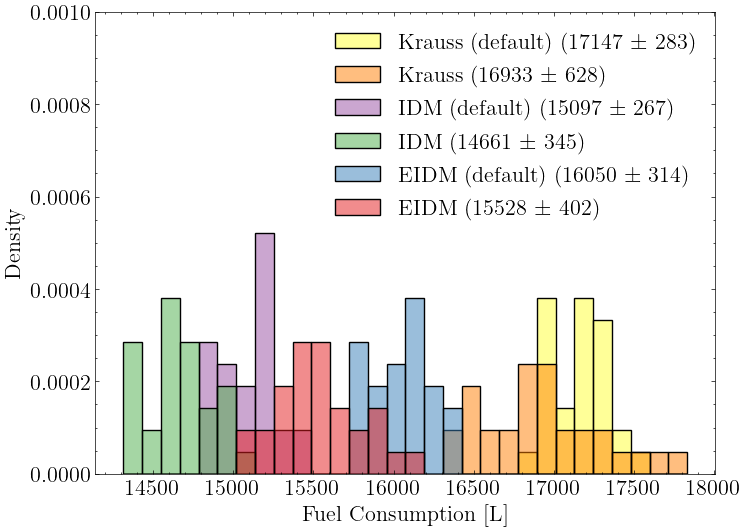

In [172]:
import matplotlib.pyplot as plt
import scienceplots
import seaborn as sns


plt.style.use("science")

fig, ax = plt.subplots(figsize=(8, 6))
# make the text bigger
plt.rcParams.update({"font.size": 16})
colors = sns.color_palette("Set1", n_colors=fuel_df["carFollowModel"].nunique())

grouped_df = fuel_df.groupby(["carFollowModel", "seed"]).sum().reset_index()

sns.histplot(
    data=grouped_df, 
    x="fuel", 
    hue="carFollowModel", 
    stat="density", 
    ax=ax, 
    bins=30, 
    legend=True, 
    palette=colors, 
)
# remove the carFollowingModel title from the legend

ax.legend_.set_title(None)

# set the legend to include the mean and median
labels = [t.get_text() for t in ax.get_legend().get_texts()][::-1]
labels = [
    f"{label} ({tmp_df.loc[label, 'mean']} ± {tmp_df.loc[label, 'upper'] - tmp_df.loc[label, 'mean']})"
    for label in labels
]
ax.legend(labels=labels)

ax.set_ylim(0, 0.001)

# set the x and y axis labels
ax.set_xlabel("Fuel Consumption [L]")
ax.set_ylabel("Density")


In [165]:
ax.legend_.get_texts()[0].get_text()

'EIDM'

In [140]:
START_TIME = pd.to_datetime('2020-02-24 05:30:00')

fuel_df['dt'] = fuel_df['time'].apply(lambda x: START_TIME + pd.Timedelta(seconds=x))

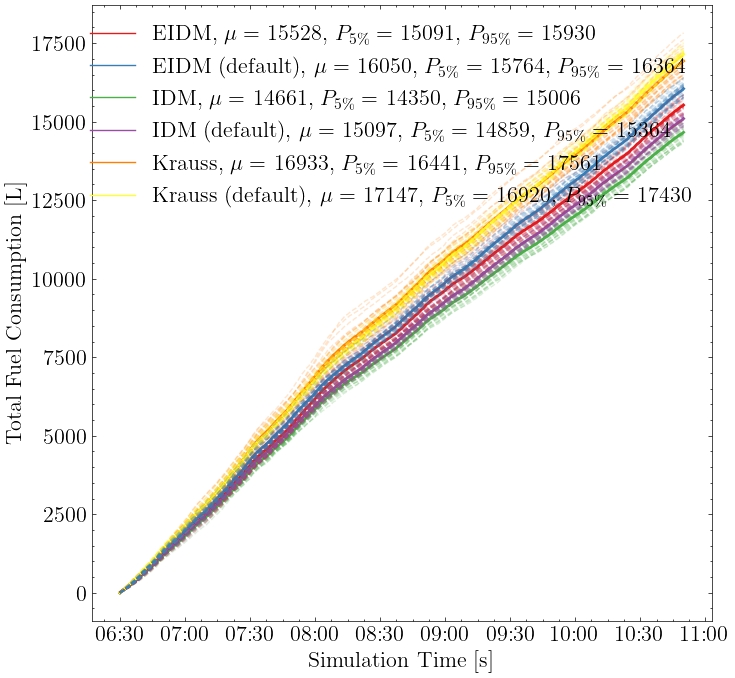

In [142]:
plt.style.use("science")
fig, ax = plt.subplots(figsize=(8, 8))
plt.rcParams.update({"font.size": 16})


# get three colors
colors = sns.color_palette("Set1", n_colors=fuel_df["carFollowModel"].nunique())

_df = fuel_df.groupby(["carFollowModel", "dt"])[['fuel']].mean().groupby("carFollowModel").cumsum().reset_index()
_df.sort_values(by=["carFollowModel", "dt"], inplace=True)

palette = {m: colors[i] for i, m in enumerate(_df["carFollowModel"].unique())}


sns.lineplot(
    data=_df,
    x="dt",
    y="fuel",
    hue="carFollowModel",
    ax=ax,
    legend=True,
    linewidth=2,
    palette=palette,
)

# remove the carFollowingModel title from the legend
ax.legend_.set_title(None)
# remove the legend items that are not in the palette
handles, labels = ax.get_legend_handles_labels()
for handle in handles:
    if handle.get_label() in palette:
        handle.set_label(
            f"{handle.get_label()}, $\mu = $ {tmp_df.loc[handle.get_label()]['mean']}, " + "$P_{5\%} = $ " + f"{tmp_df.loc[handle.get_label()]['lower']}, " + "$P_{95\%} = $ " + f"{tmp_df.loc[handle.get_label()]['upper']}"
        )
    else:
        handle.set_visible(False)
ax.legend(handles=handles)

for cf_model in fuel_df["carFollowModel"].unique():
    labels.append(cf_model)
    for seed in fuel_df["seed"].unique():
        # create a line plot of the cummulatve sum of fuel
        _df = fuel_df[(fuel_df["carFollowModel"] == cf_model) & (fuel_df["seed"] == seed)].copy()
        _df["fuel"] = _df["fuel"].cumsum()

        sns.lineplot(
            data=_df,
            x="dt",
            y="fuel",
            ax=ax,
            color=palette[cf_model],
            alpha=0.2,
            linestyle="--",
        )

ax.set_ylabel("Total Fuel Consumption [L]")
ax.set_xlabel("Simulation Time [s]")
from matplotlib.dates import DateFormatter

ax.xaxis.set_major_formatter(DateFormatter("%H:%M"))

<AxesSubplot: xlabel='fuel', ylabel='Proportion'>

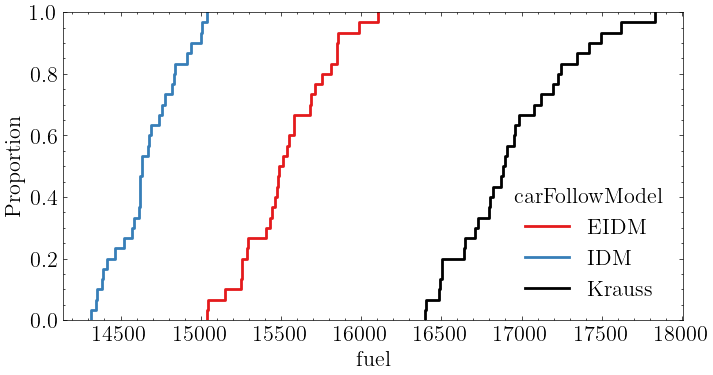

In [14]:
import matplotlib.pyplot as plt
import scienceplots
import seaborn as sns
import numpy as np
import matplotlib.patches as mpatches

plt.style.use("science")
fig, ax = plt.subplots(figsize=(8, 4))
plt.rcParams.update({"font.size": 16})



colors = sns.color_palette("Set1", n_colors=len(fuel_df["carFollowModel"].unique()))
colors[-1] = "black"

_fuel_df = fuel_df.groupby(["carFollowModel", "seed"]).sum().reset_index()

sns.ecdfplot(
    data=_fuel_df,
    x="fuel",
    hue="carFollowModel",
    ax=ax,
    palette=colors,
    linewidth=2,
    legend=True,
)

# labels = []
# for i, model in enumerate(plot_df["carFollowingModel"].unique()):
#     labels += [model]
#     if model == "Real World":
#         continue
#     for seed in plot_df[plot_df["carFollowingModel"] == model]["seed"].unique():
#         # if the seed is the mean, plot it in black
#         data = plot_df.loc[
#             (plot_df["carFollowingModel"] == model) & (plot_df["seed"] == seed), "speed"
#         ].values
#         sns.lineplot(
#             x=np.sort(data),
#             y=np.linspace(0, 1, len(data)),
#             ax=ax,
#             color=colors[i],
#             alpha=0.2,
#             linewidth=1,
#             legend=False,
#         )

# # # sns.ecdfplot(data=plot_df, x="slope", hue="carFollowingModel", stat="proportion", ax=ax, )
# # # remove the carFollowingModel title from the legend
# # ax.legend_.set_title(None)

# # # set the legend to include the mean and median
# labels = [
#     f"{label}, $\mu = $ {plot_df[plot_df['carFollowingModel'] == label]['speed'].mean():.2f}, " + "$P_{50\%} = $ " + f"{plot_df[plot_df['carFollowingModel'] == label]['speed'].median():.2f}"
#     for label in labels
# ][::-1]

# ax.legend(labels=labels)


# # set the x and y axis labels
# ax.set_xlabel("Speed [km/h]")


# # set the x and y axis limits
# ax.set_xlim(55, 120)
